# Hemoglobin

Based on “Network-Level Allosteric Effects Are Elucidated by Detailing How Ligand-Binding Events Modulate Utilization of Catalytic Potentials."

__URL:__ https://doi.org/10.1371/journal.pcbi.1006356

In [1]:
from os import path

from cobra import DictList

import matplotlib.pyplot as plt

from sympy import Equality, Symbol, solveset, sympify, pprint

import mass
from mass import (
    MassMetabolite, MassModel, MassReaction, 
    Simulation, UnitDefinition)
from mass.io import json
from mass.util import strip_time, qcqa_model

print("MASSpy version: " + mass.__version__)

MASSpy version: 0.1.0a42


## Load Glycolysis

In [2]:
# Load the glycolysis model
glycolysis = json.load_json_model(
    filename=path.realpath(path.join("models", "Glycolysis.json")))

Academic license - for non-commercial use only


## Model Construction 


In [3]:
hemoglobin = MassModel("Hemoglobin")

### Metabolites

In [4]:
hb_c = MassMetabolite(
    "hb_c", 
    name="Hemoglobin", 
    formula="[HB]",
    charge=0,
    compartment="c",
    fixed=False)

hb_1o2_c = MassMetabolite(
    "hb_1o2_c", 
    name="Oxyhemoglobin (1)", 
    formula="[HB]-O2",
    charge=0,
    compartment="c",
    fixed=False)

hb_2o2_c = MassMetabolite(
    "hb_2o2_c", 
    name="Oxyhemoglobin (2)", 
    formula="[HB]-O4",
    charge=0,
    compartment="c",
    fixed=False)

hb_3o2_c = MassMetabolite(
    "hb_3o2_c", 
    name="Oxyhemoglobin (3)", 
    formula="[HB]-O6",
    charge=0,
    compartment="c",
    fixed=False)

hb_4o2_c = MassMetabolite(
    "hb_4o2_c", 
    name="Oxyhemoglobin (4)", 
    formula="[HB]-O8",
    charge=0,
    compartment="c",
    fixed=False)

dhb_c = MassMetabolite(
    "dhb_c", 
    name="Deoxyhemoglobin", 
    formula="[HB]-C3H3O10P2",
    charge=-5,
    compartment="c",
    fixed=False)

_23dpg_c = MassMetabolite(
    "_23dpg_c", 
    name="2,3-Disphospho-D-glycerate", 
    formula="C3H3O10P2",
    charge=-5,
    compartment="c",
    fixed=False)

_13dpg_c = MassMetabolite(
    "_13dpg_c",
    name="3-Phospho-D-glyceroyl phosphate",
    formula="C3H4O10P2",
    charge=-4,
    compartment="c",
    fixed=False)

_3pg_c = MassMetabolite(
    "_3pg_c",
    name="3-Phospho-D-glycerate",
    formula="C3H4O7P",
    charge=-3,
    compartment="c",
    fixed=False)

o2_c = MassMetabolite(
    "o2_c",
    name="Oxygen",
    formula="O2",
    charge=0,
    compartment="c",
    fixed=False)

h_c = MassMetabolite(
    "h_c",
    name="H+",
    formula="H",
    charge=1,
    compartment="c",
    fixed=False)

pi_c = MassMetabolite(
    "pi_c",
    name="Phosphate",
    formula="HPO4",
    charge=-2,
    compartment="c",
    fixed=False)

h2o_c = MassMetabolite(
    "h2o_c",
    name="H2O",
    formula="H2O",
    charge=0,
    compartment="c",
    fixed=False)

### Reactions

In [5]:
DPGase = MassReaction(
    "DPGase",
    name="Diphosphoglycerate phosphatase",
    subsystem=hemoglobin.id, 
    reversible=False)
DPGase.add_metabolites({
    h2o_c: -1,
    _23dpg_c: -1,
    _3pg_c: 1,
    pi_c: 1})

DPGM = MassReaction(
    "DPGM",
    name="Diphosphoglyceromutase",
    subsystem=hemoglobin.id,
    reversible=True)
DPGM.add_metabolites({
    _13dpg_c: -1,
    _23dpg_c: 1,
    h_c: 1})

HBDPG = MassReaction(
    "HBDPG",
    name="Hemoglobin-23dpg binding",
    subsystem=hemoglobin.id,
    reversible=True)
HBDPG.add_metabolites({
    hb_c: -1,
    _23dpg_c: -1,
    dhb_c: 1})

HBO1 = MassReaction(
    "HBO1",
    name="Oxygen Loading (1)",
    subsystem=hemoglobin.id,
    reversible=True)
HBO1.add_metabolites({
    hb_c: -1,
    o2_c: -1,
    hb_1o2_c: 1})

HBO2 = MassReaction(
    "HBO2",
    name="Oxygen Loading (2)",
    subsystem=hemoglobin.id,
    reversible=True)
HBO2.add_metabolites({
    hb_1o2_c: -1,
    o2_c: -1,
    hb_2o2_c: 1})

HBO3 = MassReaction(
    "HBO3",
    name="Oxygen Loading (3)",
    subsystem=hemoglobin.id,
    reversible=True)
HBO3.add_metabolites({
    hb_2o2_c: -1,
    o2_c: -1,
    hb_3o2_c: 1})

HBO4 = MassReaction(
    "HBO4",
    name="Oxygen Loading (4)",
    subsystem=hemoglobin.id,
    reversible=True)
HBO4.add_metabolites({
    hb_3o2_c: -1,
    o2_c: -1,
    hb_4o2_c: 1})

hemoglobin.add_reactions([
    DPGase, DPGM, HBDPG, HBO1, HBO2, HBO3, HBO4])

#### Boundary Reactions

In [6]:
SK_o2_c = hemoglobin.add_boundary(
    metabolite=o2_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=0.0200788)

### Ordering of species and reactions


In [7]:
new_metabolite_order = [
    "_23dpg_c", "hb_c", "hb_1o2_c", "hb_2o2_c", 
    "hb_3o2_c", "hb_4o2_c", "dhb_c", "_13dpg_c",
    "_3pg_c",  "o2_c", "pi_c", "h_c", "h2o_c"]

if len(hemoglobin.metabolites) == len(new_metabolite_order):
    hemoglobin.metabolites = DictList(
        hemoglobin.metabolites.get_by_any(new_metabolite_order))
    
new_reaction_order = [
    "DPGM", "DPGase", "HBO1", "HBO2", 
    "HBO3", "HBO4", "HBDPG", "SK_o2_c"]

if len(hemoglobin.reactions) == len(new_reaction_order):
    hemoglobin.reactions = DictList(
        hemoglobin.reactions.get_by_any(new_reaction_order))

### Compartments

In [8]:
hemoglobin.compartments = {"c": "Cytosol"}

## Computing Steady State Concentrations

### Numerical Values

In [9]:
HB_total_symbol = Symbol("HB-Total")
numerical_values = {HB_total_symbol: 7.3}

DPGM.Keq = 2.3*1e6
HBO1.Keq = 41.8352
HBO2.Keq = 73.2115
HBO3.Keq = 177.799 
HBO4.Keq = 1289.92 
HBDPG.Keq = 1/4
SK_o2_c.Keq = 1

numerical_values.update({
    Symbol(reaction.Keq_str): reaction.Keq 
    for reaction in hemoglobin.reactions})

### Solve equations symbolically

In [10]:
metabolites = {metabolite.id: Symbol(metabolite.id) 
               for metabolite in hemoglobin.metabolites}

concentration_equations = {}
# Iterate through reactions assumed to be at equilibrium
for reaction in [HBO1, HBO2, HBO3, HBO4, HBDPG]:
    equilibrium_expression = Equality(
        Symbol(reaction.Keq_str),
        strip_time(reaction.get_mass_action_ratio()))
    # Find the hemoglobin form being made as a product (bound to most oxygen)
    hb_product = [
        Symbol(metabolite.id) for metabolite in reaction.products
        if metabolite.id not in ["_23dpg_c", "hb_c", "o2_c"]].pop()
    # Solve equation for the desired form hemoglobin 
    equation = solveset(equilibrium_expression, hb_product)
    equation = next(iter(equation))
    # Update equilibrium expression dict with the equation
    # for the bound form of hemoglobin. These equations will
    # be dependent on hb_c, o2_c, and _23dpg_c.
    concentration_equations.update({
        hb_product: equation.subs(concentration_equations)})
# Specify an equation for the total amount of hemoglobin
HB_total = Equality(
    HB_total_symbol,
    sympify("+".join([
        metabolite.id for metabolite in hemoglobin.metabolites
        if "hb" in metabolite.id]), locals=metabolites))
HB_total = HB_total.subs(concentration_equations)
concentration_equations.update({
    hb_form: equation.subs(numerical_values)
    for hb_form, equation in concentration_equations.items()})
HB_total = HB_total.subs(numerical_values)

# Define known concentrations
concentrations = {
    metabolites["_23dpg_c"]: 3.1, 
    metabolites["o2_c"]: 70*2.8684*1e-4}
# Convert the solution into a numerical value
hb_conc =  next(iter(solveset(
    HB_total.subs(concentrations),
    Symbol("hb_c"))))
concentrations.update({metabolites["hb_c"]: hb_conc})
# Solve for the rest of the hemoglobin concentrations
for hb_form, equation in concentration_equations.items():
    equation = equation.subs(concentrations)
    concentrations.update({hb_form: equation})

### Set initial conditions

In [11]:
for metabolite_symbol, value_symbol in concentrations.items():
    metabolite = hemoglobin.metabolites.get_by_id(str(metabolite_symbol))
    metabolite.ic = float(value_symbol)

for met in hemoglobin.metabolites:
    if met.ic is None:
        met.ic = glycolysis.metabolites.get_by_id(str(met)).ic

## Model Parameterization
### Steady State Fluxes

In [12]:
DPGM.v = 0.441
DPGase.v = 0.441
HBO1.v = 0
HBO2.v = 0
HBO3.v = 0
HBO4.v = 0
HBDPG.v = 0
SK_o2_c.v = 0

### PERCs

In [13]:
hemoglobin.calculate_PERCs(update_reactions=True)

HBO1.kf = 506935
HBO2.kf = 511077
HBO3.kf = 509243
HBO4.kf = 501595
HBDPG.kf =519613
SK_o2_c.kf = 509726

### Units

In [14]:
concentration = UnitDefinition("mM", name="Millimolar", list_of_units=["millimole", "per_litre"])
time = UnitDefinition("hr", name="hour", list_of_units=["hour"])

hemoglobin.add_units([concentration, time])

## QC Model


In [15]:
qcqa_model(hemoglobin,  parameters=True, concentrations=True, 
           fluxes=True, superfluous=True, elemental=True)

╒══════════════════════════════════════════╕
│ MODEL ID: Hemoglobin                     │
│ SIMULATABLE: True                        │
│ PARAMETERS NUMERICALY CONSISTENT: True   │
╞══════════════════════════════════════════╡
╘══════════════════════════════════════════╛


## Simulation

Read LP format model from file /var/folders/36/g2np3l0d6t9dyr4rk3tvc8f80000gn/T/tmp2fg8e_ml.lp
Reading time = 0.00 seconds
: 20 rows, 44 columns, 122 nonzeros
Successfully loaded MassModel 'Glycolysis_Hemoglobin' into RoadRunner.


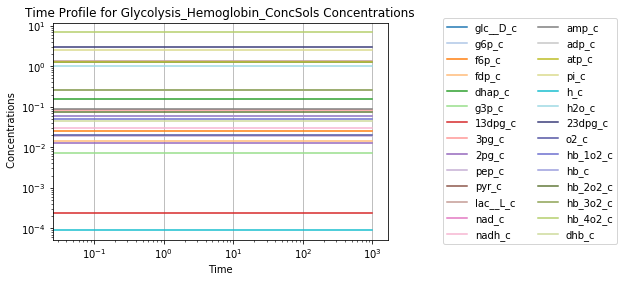

In [16]:
glycolysis_hb = glycolysis.merge(hemoglobin, inplace=False)
sim = Simulation(glycolysis_hb, verbose=True)
sim.find_steady_state(glycolysis_hb, strategy="simulate",
                      update_values=True)
conc_sol, flux_sol = sim.simulate(glycolysis_hb, time=(0, 1e3, 1e4 + 1))
conc_sol.view_time_profile()

## Export

In [17]:
json.save_json_model(
    mass_model=hemoglobin,
    filename=path.realpath(path.join("models", hemoglobin.id + ".json")))